# Custom Spam Filtering

In [1]:
from google.colab import files
uploaded = files.upload()

Saving SMSSpamCollection to SMSSpamCollection


## Install Huggingface Transformers

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 83.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 65.0 MB/s eta 0:00:00


### Import Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from transformers import DistilBertTokenizer
from transformers import DistilBertForSequenceClassification
import torch
from torch.utils.data import TensorDataset, DataLoader

## Read Data

In [4]:
# Load the data into a pandas dataframe
df = pd.read_csv('SMSSpamCollection', sep='\t', names=["label", "text"])

## Preprocessing

In [5]:
# Preprocessing the data to prepare it for training
# Get the values of the text and label columns
texts = df['text'].values
labels = df['label'].values

### Label Encoding

In [6]:
# Encode the labels to integer values
encoder = LabelEncoder()
labels = encoder.fit_transform(labels)

## Tokenization

In [7]:
# Tokenize the texts using the DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
tokenized_texts = [tokenizer.encode(text, add_special_tokens=True) for text in texts]

### Padding

In [8]:
# Pad the tokenized texts to have a uniform length
max_len = max([len(text) for text in tokenized_texts])
padded_texts = [text + [0] * (max_len - len(text)) for text in tokenized_texts]

## Train Test Split

In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_texts, labels, test_size=0.2)

## Convert to Tensors

In [10]:
# Convert the data to tensors for use with PyTorch
X_train_tensor = torch.tensor(X_train)
X_test_tensor = torch.tensor(X_test)
y_train_tensor = torch.tensor(y_train)
y_test_tensor = torch.tensor(y_test)

## Dataset and Dataloaders

In [11]:
# Create TensorDataset and DataLoader objects for the training and testing sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model

### Initialize Model

In [12]:
# Load a pretrained DistilBertForSequenceClassification model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

In [13]:
# Set the device
# Use GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

### Hyperparameters

In [14]:
learning_rate = 1e-5
num_epochs = 10

### Loss Function and Optimizer

In [15]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Train Model

In [16]:
# Train the model
train_loss_values = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)[0]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 50 == 49:
            print(f"Epoch: {epoch} Iteration: {i} Loss: {running_loss/50}")
            train_loss_values.append(running_loss/50)
            running_loss = 0.0

Epoch: 0 Iteration: 49 Loss: 0.31662135019898413
Epoch: 0 Iteration: 99 Loss: 0.16665009930729865
Epoch: 1 Iteration: 49 Loss: 0.055272470079362396
Epoch: 1 Iteration: 99 Loss: 0.03763339942321181
Epoch: 2 Iteration: 49 Loss: 0.027464376580901444
Epoch: 2 Iteration: 99 Loss: 0.03126491064205766
Epoch: 3 Iteration: 49 Loss: 0.016619020807556808
Epoch: 3 Iteration: 99 Loss: 0.017835708814673126
Epoch: 4 Iteration: 49 Loss: 0.012206217665225267
Epoch: 4 Iteration: 99 Loss: 0.014587923991493881
Epoch: 5 Iteration: 49 Loss: 0.010863414311315864
Epoch: 5 Iteration: 99 Loss: 0.007037458680570125
Epoch: 6 Iteration: 49 Loss: 0.001213615781161934
Epoch: 6 Iteration: 99 Loss: 0.0054371891473419965
Epoch: 7 Iteration: 49 Loss: 0.008847338538616896
Epoch: 7 Iteration: 99 Loss: 0.008469896877650172
Epoch: 8 Iteration: 49 Loss: 0.004941991372033954
Epoch: 8 Iteration: 99 Loss: 0.008699414131697267
Epoch: 9 Iteration: 49 Loss: 0.011864398869220168
Epoch: 9 Iteration: 99 Loss: 0.004115442164475098


### Plot Training Loss

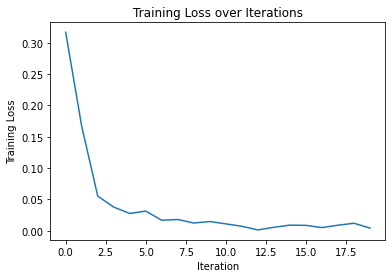

In [17]:
plt.plot(np.arange(len(train_loss_values)), train_loss_values)
plt.title("Training Loss over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Training Loss")
plt.show()

## Evaluate Model

In [18]:
# Evaluation
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs[0], 1)
        # Save the predictions for later use
        predictions.extend(predicted.cpu().numpy().tolist())
        true_labels.extend(labels.cpu().numpy().tolist())


## Performance Metrics

In [19]:
# Calculating the F1 Score
f1 = f1_score(true_labels, predictions, average='macro')
print(f"F1 Score: {f1}")
# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(true_labels, predictions))
# Classification Report
print("Classification Report:")
print(classification_report(true_labels, predictions))


F1 Score: 0.9753434956952471
Confusion Matrix:
[[970   0]
 [ 12 133]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       970
           1       1.00      0.92      0.96       145

    accuracy                           0.99      1115
   macro avg       0.99      0.96      0.98      1115
weighted avg       0.99      0.99      0.99      1115



In [25]:
# Save Classification Model for inferencing
torch.save({
            'epoch': num_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'checkpoint.pth')

files.download('checkpoint.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>